# Team 6 Project: Clustering basado en PCA

This notebook is in charge of modeling clusters for analysis of redivist profiles based on education levels, conviction place, crime, gender, and activities during conviction.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import powerlaw as plw
import networkx as nx
import community as community_louvain
import seaborn as sns
pd.options.display.max_columns = 50

path = "https://raw.githubusercontent.com/sagilar/ds4a-team6/master/retomintic/Data_UpdateJune13/reincidencia11junio2020_clean.csv"
df_mj = pd.read_csv(path, sep=",",encoding="utf-8")

# Data

some data preprocessing is caried out in this section.

In [3]:
#Date variables are parsed to datetime
df_mj["FECHA_CAPTURA"] = pd.to_datetime(df_mj["FECHA_CAPTURA"])
df_mj["FECHA_INGRESO"] = pd.to_datetime(df_mj["FECHA_INGRESO"])
df_mj["FECHA_SALIDA"] = pd.to_datetime(df_mj["FECHA_SALIDA"])
#Month and year variables are defined
df_mj["MES_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%m')
df_mj["ANO_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%y')
#Calculations on how much time have the criminal being outside since its last stay in jail
for column in ['FECHA_INGRESO', 'FECHA_SALIDA', 'FECHA_CAPTURA']:
    df_mj = df_mj.sort_values(['INTERNOEN', column], ascending = False)
    
    df_mj['DIAS' + column[5:]] = -1*(df_mj[column].diff()/timedelta(days = 1))

    df_mj.loc[(df_mj.INTERNOEN != df_mj.INTERNOEN.shift(1)) | (df_mj['DIAS' + column[5:]] == 0), 
              ['DIAS' + column[5:]]] = (datetime.today() - df_mj[column])/timedelta(days = 1)
    
#It seems that sometimes entering and gettint out is switched, that's why we computed in absolute values
df_mj['DIAS_CONDENA'] = abs(df_mj['FECHA_SALIDA'] - df_mj['FECHA_INGRESO'])/timedelta(days = 1)
df_mj['DIAS_JUDICIALIZACION'] = df_mj['FECHA_INGRESO'] - df_mj['FECHA_CAPTURA']
df_mj['DIAS_LIBRE'] = df_mj['DIAS_INGRESO'] - df_mj['DIAS_CONDENA']
#The individual finishes its sentence but she's incarcelated inmediately for another crime
df_mj.loc[df_mj.DIAS_CAPTURA < 0, 'DIAS_CAPTURA'] = 0
df_mj.loc[df_mj.DIAS_INGRESO < 0, 'DIAS_INGRESO'] = 0
df_mj.loc[df_mj.DIAS_LIBRE < 0, 'DIAS_LIBRE'] = 0
#The individual is still on jail
df_mj.loc[df_mj['DIAS_LIBRE'].isnull(), 'DIAS_LIBRE'] = 0

#Find the last date the criminal went out the jail, so that these observations are marked as censored
last_df = df_mj[['INTERNOEN', 'FECHA_INGRESO']].groupby('INTERNOEN').apply(lambda x: x.sort_values('FECHA_INGRESO', ascending = False).head(1)).reset_index(drop = True)
#Censored
last_df['CENSURADO_LIBRES'] = 0
df_mj = df_mj.merge(last_df, on = ['INTERNOEN', 'FECHA_INGRESO'], how = 'left')
#Event
df_mj.loc[df_mj['CENSURADO_LIBRES'].isnull(), 'CENSURADO_LIBRES'] = 1
#All criminals that haven't got out of jail yet have zero days out and they are not censored.
df_mj.loc[df_mj['FECHA_SALIDA'].isnull(), 'CENSURADO_LIBRES'] = 1
#Turned censored variables to integers instead of float
df_mj['CENSURADO_LIBRES'] = df_mj['CENSURADO_LIBRES'].astype('int64')

#We create a variable to count the amount of times the individual re-entered in jail
df_mj = df_mj.merge(df_mj.drop_duplicates(['INTERNOEN', 'FECHA_INGRESO']).groupby(['INTERNOEN']).size().reset_index(name = 'NUMERO_REINCIDENCIAS'), on = 'INTERNOEN', how = 'left')

#We create a variable to count the number of crimes the individual commited on this times
df_mj = df_mj.merge(df_mj.groupby(['INTERNOEN', 'FECHA_INGRESO']).size().to_frame('CRIMENES').reset_index(), on = ['INTERNOEN', 'FECHA_INGRESO'])
                    
#We dropped SITUACION_JURIDICA and REINCIDENTE as both columns are constants
df_mj = df_mj.drop(columns = ['SITUACION_JURIDICA', 'REINCIDENTE'])

#Find the correlation across crimes
crime = df_mj[['INTERNOEN', 'DELITO']]
crime = crime.groupby(['INTERNOEN', 'DELITO']).size().reset_index()
crime.columns = ['id', 'crime', 'count']
crime = crime.pivot(index='id', columns='crime', values = 'count').fillna(0)
corr = crime.corr()

#From correlation matrix get similarity function
edge_dict = {}
h = 0
for i in np.arange(corr.shape[0]):
    for  j in np.arange(corr.shape[1]):
        if i > j:
            edge_dict[h] = [corr.columns[i], corr.columns[j], corr.iloc[i, j]]
        h+=1

#Similarity get defined
pd_edges = pd.DataFrame.from_dict(edge_dict).T
pd_edges.columns = ['source', 'target', 'weight']
pd_edges['weight'] = pd_edges['weight'].astype(float)
pd_edges.weight = (pd_edges.weight.max() - pd_edges.weight)

#Threshold on the correlation
distance_threshold = 0.6925
pd_edges['reduced_weight'] = pd_edges.weight
pd_edges.loc[pd_edges.weight > distance_threshold, 'reduced_weight'] = 0
pd_edges['similarity'] = 1 - pd_edges.reduced_weight/pd_edges.reduced_weight.max()
pd_edges.loc[pd_edges.similarity == 1, 'similarity'] = 0

#Define graph from threshold on the similarity
graph = nx.from_pandas_edgelist(pd_edges.loc[pd_edges.similarity > 0, ['source', 'target', 'weight']])
edges_result = pd_edges.loc[pd_edges.similarity > 0, ['source', 'target', 'similarity']]

#Find partitions from Louvain heuristics
partition = community_louvain.best_partition(graph)

#Add partition to node list
nodes_result = pd.DataFrame.from_dict(partition.items())
nodes_result.columns = ['Id', 'community'] 
nodes_result['label'] = nodes_result['Id']

#Add degrees to node list
nodes_result = nodes_result.merge(pd.DataFrame(graph.degree, columns = ['Id', 'degree']), on = 'Id')

#Add centrality to node list
centrality = pd.DataFrame.from_dict(nx.eigenvector_centrality(graph).items()).reset_index(drop = True)
centrality.columns = ['Id', 'eigencentrality']
nodes_result = nodes_result.merge(centrality, on = 'Id')

#Add graph information to data
df_mj = df_mj.merge(nodes_result[['Id', 'community', 'eigencentrality', 'degree']], left_on = 'DELITO', right_on = 'Id')

#Add how many times a crime repeats
delitos_df = pd.DataFrame(df_mj.DELITO.value_counts().sort_values()).reset_index()
delitos_df['logDelito'] = np.log(delitos_df.DELITO) + 1
df_mj = df_mj.merge(delitos_df[['index', 'logDelito']], left_on = 'DELITO', right_on = 'index')

#Add dummy to test whether the individuals was in jaiñ 
df_mj['EN_CARCEL'] = 0
df_mj.loc[df_mj['ESTADO_INGRESO'].isin(['Espera Traslado', 'Intramuros']),'EN_CARCEL'] = 1

#Makes more readable the education years
df_mj['NIVEL_EDUCATIVO'] = df_mj['NIVEL_EDUCATIVO'].map(
            {'ANALFABETA': 0, 'CICLO I': 2, 'CICLO II': 5, 'CICLO III': 9,
            'CICLO IV': 11, 'TECNICO': 13, 'TECNOLOGICO': 14, 'PROFESIONAL': 16,
            'MAGISTER': 18, 'POST GRADO': 18})

In [4]:
df_mj['INTERNOEN'].value_counts()[df_mj['INTERNOEN']].values

array([3, 1, 3, ..., 3, 6, 2])

In [5]:
df_mj = df_mj.merge(df_mj.groupby(['INTERNOEN', 'FECHA_INGRESO']).size().to_frame('CRIMENES').reset_index(), on = ['INTERNOEN', 'FECHA_INGRESO'])

the categorical variables are declared.

In [6]:
cuantitativas = ['EDAD', 'NIVEL_EDUCATIVO', 'MES_INGRESO_INT', 'ANO_INGRESO_INT', 'DIAS_INGRESO', 'DIAS_SALIDA', 'DIAS_CAPTURA', 'DIAS_JUDICIALIZACION', 'DIAS_LIBRE', 'NUMERO_REINCIDENCIAS', 'CRIMENES', 'eigencentrality', 'degree', 'logDelito']
categoricas = ['TENTATIVA', 'AGRAVADO', 'CALIFICADO', 'GENERO', 'GENERO', 'REGIONAL', 'HIJOS_MENORES', 'ESTADO', 'community', 'EN_CARCEL', 'CENSURADO_LIBRES','ACTIVIDADES_TRABAJO','ACTIVIDADES_ESTUDIO','ACTIVIDADES_ENSEÑANZA']
df_mj

,INTERNOEN,DELITO,TITULO_DELITO,SUBTITULO_DELITO,TENTATIVA,AGRAVADO,CALIFICADO,FECHA_INGRESO,FECHA_SALIDA,FECHA_CAPTURA,ANO_NACIMIENTO,EDAD,GENERO,ESTADO_CIVIL,PAIS_INTERNO,DEPARTAMENTO,CIUDAD,ESTADO_INGRESO,ACTIVIDADES_TRABAJO,ACTIVIDADES_ESTUDIO,ACTIVIDADES_ENSEÑANZA,NIVEL_EDUCATIVO,HIJOS_MENORES,CONDIC_EXPECIONAL,CODIGO_ESTABLECIMIENTO,ESTABLECIMIENTO,DEPTO_ESTABLECIMIENTO,MPIO_ESTABLECIMIENTO,REGIONAL,ESTADO,MES_INGRESO_INT,ANO_INGRESO_INT,DIAS_INGRESO,DIAS_SALIDA,DIAS_CAPTURA,DIAS_CONDENA,DIAS_JUDICIALIZACION,DIAS_LIBRE,CENSURADO_LIBRES,NUMERO_REINCIDENCIAS,CRIMENES_x,Id,community,eigencentrality,degree,index,logDelito,EN_CARCEL,CRIMENES_y
0,FFFFB0916FD16C7AF652FF211662005C40F70E33,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,EPMSC MEDELLIN,ANTIOQUIA,MEDELLIN,NOROESTE,Activo,05,16,1552.723041,NaN,1642.72306,NaN,90 days,0.000000,1,1,3,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,2,0.055566,8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,10.730086,1,3
1,FFFFB0916FD16C7AF652FF211662005C40F70E33,HOMICIDIO,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,DE LA MANIPULACION GENETICA,N,S,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,EPMSC MEDELLIN,ANTIOQUIA,MEDELLIN,NOROESTE,Activo,05,16,1552.723041,NaN,1642.72306,NaN,90 days,0.000000,1,1,3,HOMICIDIO,2,0.117027,18,HOMICIDIO,10.093469,1,3
2,FFFFB0916FD16C7AF652FF211662005C40F70E33,HOMICIDIO,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,DE LA MANIPULACION GENETICA,S,N,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,EPMSC MEDELLIN,ANTIOQUIA,MEDELLIN,NOROESTE,Activo,05,16,1552.723041,NaN,1642.72306,NaN,90 days,0.000000,1,1,3,HOMICIDIO,2,0.117027,18,HOMICIDIO,10.093469,1,3
3,FFFE667F85CF452DB70B955609103CB72ECA3EEB,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2020-01-14,NaT,2019-12-16,1984,36,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,NORTE DE SANTANDER,CUCUTA-NORTE DE SANTANDER,Intramuros,SI,NO,NO,5.0,SI,NaN,4222,COMPLEJO CARCELARIO Y PENITENCIARIO METROPOLIT...,NORTE DE SANTANDER,CUCUTA,ORIENTE,Activo,01,20,200.723041,NaN,229.72306,NaN,29 days,0.000000,1,1,1,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,2,0.055566,8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,10.730086,1,1
4,FFFADAD55F03CF9CCDFBC89749D5C1F96C1CBDCF,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2017-03-11,2018-08-06,2014-09-13,1974,46,MASCULINO,NaN,REPUBLICA DE COLOMBIA,SANTANDER,VELEZ-SANTANDER,Prision Domiciliaria,SI,SI,NO,2.0,SI,NaN,113,COMPLEJO CARCELARIO Y PENITENCIARIO METROPOLIT...,BOGOTA D.C.,BOGOTA D.C.,CENTRAL,Baja,03,17,1239.723041,726.72305,2149.72306,513.0,910 days,726.723041,0,2,2,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,2,0.055566,8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,10.730086,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141309,56D98505E3C50A60B417E06A243EB2A3F54398B8,"EMPLEO, PRODUCCION, COMERCIALIZACION Y ALMACEN...",CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2020-08-01,2020-04-24,2019-12-27,1982,37,MASCULINO,NaN,REPUBLICA DE COLOMBIA,TIBU-NORTE DE SANTANDER,LA GABARRA-TIBU-NORTE DE SANTANDER,Prision Domiciliaria,SI,NO,NO,2.0,NO,NaN,4222,COMPLEJO CARCELARIO Y PENITENCIARIO METROPOLIT...,NORTE DE SANTANDER,CUCUTA,ORIENTE,Baja,08,20,0.723041,99.72305,218.72306,99.0,218 days,0.000000,0,2,1,"EMPLEO, PRODUCCION, COMERC

The one-hot encoding format is applied.

In [7]:
df_dummies = pd.get_dummies(df_mj[categoricas].astype(object), drop_first = True)
df_dummies

,TENTATIVA_S,AGRAVADO_S,CALIFICADO_S,GENERO_MASCULINO,GENERO_MASCULINO,REGIONAL_NOROESTE,REGIONAL_NORTE,REGIONAL_OCCIDENTE,REGIONAL_ORIENTE,REGIONAL_VIEJO CALDAS,HIJOS_MENORES_SI,ESTADO_Baja,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,community_10,EN_CARCEL_1,CENSURADO_LIBRES_1,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,ACTIVIDADES_ENSEÑANZA_SI
0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0
1,0,1,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0
2,1,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0
3,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0
4,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141309,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
141310,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
141311,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
141312,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0


In [8]:
df_mj_cp = df_mj.copy()
df_mj_cp = pd.concat([df_mj_cp,df_dummies],axis=1)
df_mj_cp['CANTIDAD_DELITOS'] = df_mj_cp['INTERNOEN'].value_counts()[df_mj_cp['INTERNOEN']].values
df_mj_cp['GENERO_MASCULINO_DBG']=df_mj_cp['GENERO_MASCULINO'].iloc[:,0]
df_mj_cp.drop(columns="GENERO_MASCULINO",inplace=True)
df_mj_cp['GENERO_MASCULINO'] = df_mj_cp['GENERO_MASCULINO_DBG']
df_mj_cp.drop(columns="GENERO_MASCULINO_DBG",inplace=True)
df_mj_cp.head()

,INTERNOEN,DELITO,TITULO_DELITO,SUBTITULO_DELITO,TENTATIVA,AGRAVADO,CALIFICADO,FECHA_INGRESO,FECHA_SALIDA,FECHA_CAPTURA,ANO_NACIMIENTO,EDAD,GENERO,ESTADO_CIVIL,PAIS_INTERNO,DEPARTAMENTO,CIUDAD,ESTADO_INGRESO,ACTIVIDADES_TRABAJO,ACTIVIDADES_ESTUDIO,ACTIVIDADES_ENSEÑANZA,NIVEL_EDUCATIVO,HIJOS_MENORES,CONDIC_EXPECIONAL,CODIGO_ESTABLECIMIENTO,...,CALIFICADO_S,REGIONAL_NOROESTE,REGIONAL_NORTE,REGIONAL_OCCIDENTE,REGIONAL_ORIENTE,REGIONAL_VIEJO CALDAS,HIJOS_MENORES_SI,ESTADO_Baja,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,community_10,EN_CARCEL_1,CENSURADO_LIBRES_1,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,ACTIVIDADES_ENSEÑANZA_SI,CANTIDAD_DELITOS,GENERO_MASCULINO
0,FFFFB0916FD16C7AF652FF211662005C40F70E33,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,...,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,3,1
1,FFFFB0916FD16C7AF652FF211662005C40F70E33,HOMICIDIO,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,DE LA MANIPULACION GENETICA,N,S,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,...,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,3,1
2,FFFFB0916FD16C7AF652FF211662005C40F70E33,HOMICIDIO,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,DE LA MANIPULACION GENETICA,S,N,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,...,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,3,1
3,FFFE667F85CF452DB70B955609103CB72ECA3EEB,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2020-01-14,NaT,2019-12-16,1984,36,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,NORTE DE SANTANDER,CUCUTA-NORTE DE SANTANDER,Intramuros,SI,NO,NO,5.0,SI,NaN,4222,...,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1
4,FFFADAD55F03CF9CCDFBC89749D5C1F96C1CBDCF,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2017-03-11,2018-08-06,2014-09-13,1974,46,MASCULINO,NaN,REPUBLICA DE COLOMBIA,SANTANDER,VELEZ-SANTANDER,Prision Domiciliaria,SI,SI,NO,2.0,SI,NaN,113,...,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,3,1


In [9]:
df_mj_cp.columns

Index(['INTERNOEN', 'DELITO', 'TITULO_DELITO', 'SUBTITULO_DELITO', 'TENTATIVA',
       'AGRAVADO', 'CALIFICADO', 'FECHA_INGRESO', 'FECHA_SALIDA',
       'FECHA_CAPTURA', 'ANO_NACIMIENTO', 'EDAD', 'GENERO', 'ESTADO_CIVIL',
       'PAIS_INTERNO', 'DEPARTAMENTO', 'CIUDAD', 'ESTADO_INGRESO',
       'ACTIVIDADES_TRABAJO', 'ACTIVIDADES_ESTUDIO', 'ACTIVIDADES_ENSEÑANZA',
       'NIVEL_EDUCATIVO', 'HIJOS_MENORES', 'CONDIC_EXPECIONAL',
       'CODIGO_ESTABLECIMIENTO', 'ESTABLECIMIENTO', 'DEPTO_ESTABLECIMIENTO',
       'MPIO_ESTABLECIMIENTO', 'REGIONAL', 'ESTADO', 'MES_INGRESO_INT',
       'ANO_INGRESO_INT', 'DIAS_INGRESO', 'DIAS_SALIDA', 'DIAS_CAPTURA',
       'DIAS_CONDENA', 'DIAS_JUDICIALIZACION', 'DIAS_LIBRE',
       'CENSURADO_LIBRES', 'NUMERO_REINCIDENCIAS', 'CRIMENES_x', 'Id',
       'community', 'eigencentrality', 'degree', 'index', 'logDelito',
       'EN_CARCEL', 'CRIMENES_y', 'TENTATIVA_S', 'AGRAVADO_S', 'CALIFICADO_S',
       'REGIONAL_NOROESTE', 'REGIONAL_NORTE', 'REGIONAL_OCCIDENTE

The covariates and expected outputs for the models are declared.

In [10]:
outputs = ['CANTIDAD_DELITOS','NUMERO_REINCIDENCIAS','DIAS_LIBRE']
covariates = ['NIVEL_EDUCATIVO','logDelito','EN_CARCEL','ACTIVIDADES_TRABAJO_SI','ACTIVIDADES_ESTUDIO_SI','GENERO_MASCULINO']

an analysis of the effects of the covariates on the expected outputs is carried out.

1
3
5
7
9
11
13


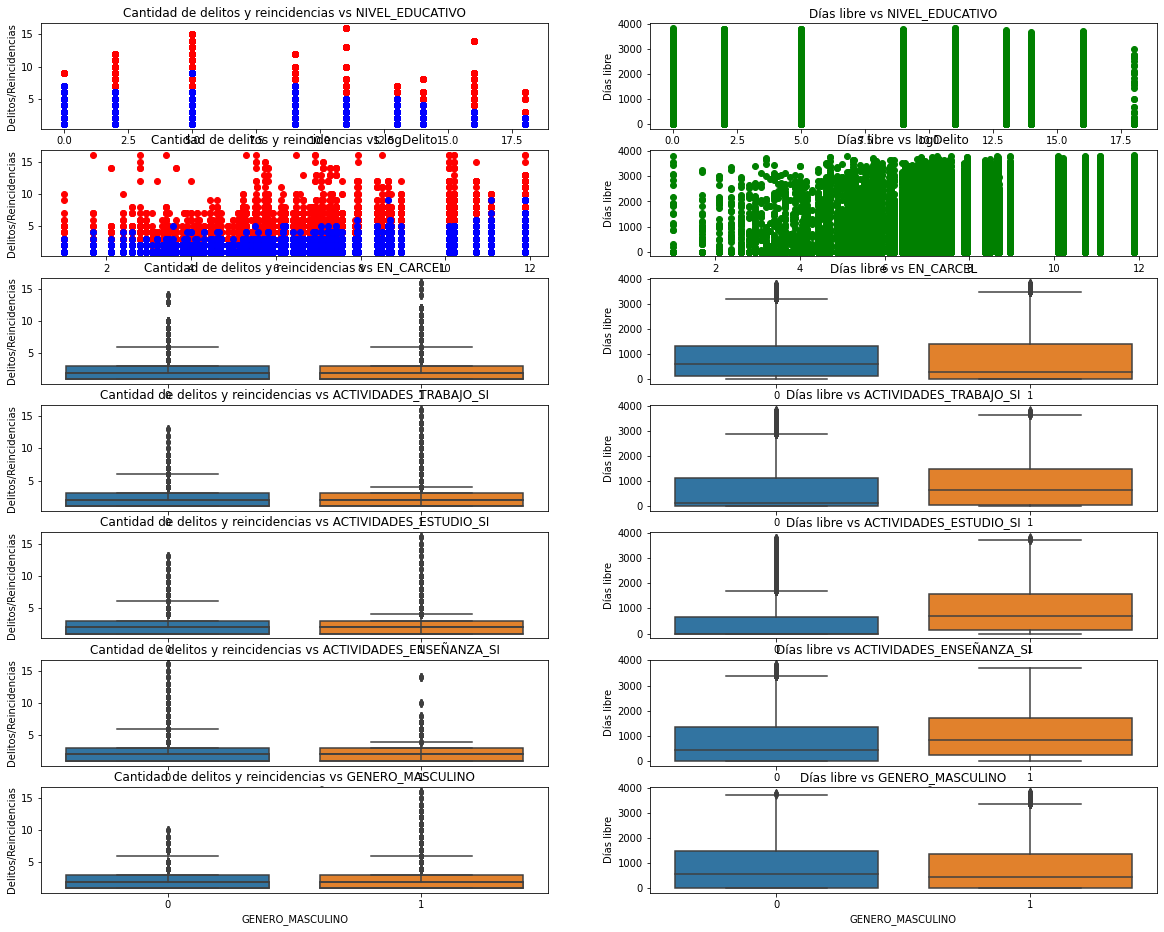

In [129]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
import math
#fig = make_subplots(rows=4,cols=2)
i=1
#fig = plt.figure(figsize=(20,16))
fig,ax = plt.subplots(math.ceil(len(covariates)),2,figsize=(20,16))
for col in covariates:
    print(i)
    if i < 5:
        plt.subplot(math.ceil(len(covariates)),2,i)

        plt.scatter(x=df_mj_cp[col],y=df_mj_cp['CANTIDAD_DELITOS'],color='red')
        plt.scatter(x=df_mj_cp[col],y=df_mj_cp['NUMERO_REINCIDENCIAS'],color='blue')
        #plt.legend(loc='best')
        plt.xlabel(col)
        plt.ylabel('Delitos/Reincidencias')
        plt.title('Cantidad de delitos y reincidencias vs ' + col)
        i=i + 1
        plt.subplot(math.ceil(len(covariates)),2,i)
        plt.scatter(x=df_mj_cp[col],y=df_mj_cp['DIAS_LIBRE'],color='green')

        #plt.legend(loc='best')
        plt.xlabel(col)
        plt.ylabel('Días libre')
        plt.title('Días libre vs ' + col)
    else:
        plt.subplot(math.ceil(len(covariates)),2,i)

        sns.boxplot(x=col,y='CANTIDAD_DELITOS',data=df_mj_cp)
        sns.boxplot(x=col,y='NUMERO_REINCIDENCIAS',data=df_mj_cp)
        #plt.legend(loc='best')
        plt.xlabel(col)
        plt.ylabel('Delitos/Reincidencias')
        plt.title('Cantidad de delitos y reincidencias vs ' + col)
        i=i + 1
        plt.subplot(math.ceil(len(covariates)),2,i)
        sns.boxplot(x=col,y='DIAS_LIBRE',data=df_mj_cp)

        #plt.legend(loc='best')
        plt.xlabel(col)
        plt.ylabel('Días libre')
        plt.title('Días libre vs ' + col)
    i = i + 1
plt.show()

In [ ]:
'''print(math.ceil(i/2))
    print(math.ceil(i/4))
    print("primer")
    fig.add_trace(go.Scatter(
        x=df_mj_cp[col],y=df_mj_cp['CANTIDAD_DELITOS'],
        row=math.ceil(i/2),col=math.ceil(i/4),
    ))
    print("seg")
    fig.add_trace(go.Scatter(
        x=df_mj_cp[col],y=df_mj_cp['NUMERO_REINCIDENCIAS'],
        row=math.ceil(i/2),col=math.ceil(i/4),
    ))
    print("terc")
    fig.add_trace(go.Scatter(
        x=df_mj_cp[col],y=df_mj_cp['DIAS_LIBRE'],
        row=math.ceil(i/2),col=math.ceil(i/4),
    ))'''
    #fig = px.scatter(df_mj_cp,x=col,y='CANTIDAD_DELITOS')
    #px.scatter(df_mj_cp,x=col,y='NUMERO_REINCIDENCIAS')
    #px.scatter(df_mj_cp,x=col,y='DIAS_LIBRE')

In [11]:
df_mj_cp[covariates].describe()

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,GENERO_MASCULINO
count,141110.000000,141314.000000,141314.000000,141314.000000,141314.000000,141314.000000
mean,6.351421,10.502450,0.604208,0.545261,0.665398,0.919385
std,3.517393,1.710422,0.489022,0.497949,0.471853,0.272244
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,10.093469,0.000000,0.000000,0.000000,1.000000
50%,5.000000,11.082596,1.000000,1.000000,1.000000,1.000000
75%,9.000000,11.880779,1.000000,1.000000,1.000000,1.000000
max,18.000000,11.880779,1.000000,1.000000,1.000000,1.000000


In [12]:
def normalize(df):
    result = df.copy()    
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)    
    return result

The data is normalized and then, some weights for the variables which are expected to model are allocated.

In [13]:
df_norm_covariates = normalize(df_mj_cp[covariates])
df_norm_outputs = normalize(df_mj_cp[outputs])
df_norm_covariates.fillna(0,inplace=True)
df_norm_outputs.fillna(0,inplace=True)

In [14]:
df_nonorm_covariates = df_mj_cp[covariates].copy()
df_nonorm_covariates.fillna(0,inplace=True)
df_nonorm_outputs = df_mj_cp[outputs].copy()
df_nonorm_outputs.fillna(0,inplace=True)

In [15]:
df_norm_covariates['logDelito'] = df_norm_covariates['logDelito']*2.5
df_norm_covariates['NIVEL_EDUCATIVO'] = df_norm_covariates['NIVEL_EDUCATIVO']*1.8
df_norm_covariates['GENERO_MASCULINO'] = df_norm_covariates['GENERO_MASCULINO']*1
df_norm_covariates

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,GENERO_MASCULINO
0,1.1,2.235613,1.0,1.0,0.0,1.0
1,1.1,2.089342,1.0,1.0,0.0,1.0
2,1.1,2.089342,1.0,1.0,0.0,1.0
3,0.5,2.235613,1.0,1.0,0.0,1.0
4,0.2,2.235613,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
141309,0.2,0.159260,0.0,1.0,0.0,1.0
141310,1.1,0.159260,1.0,1.0,0.0,1.0
141311,0.5,0.159260,1.0,0.0,0.0,1.0
141312,0.2,0.159260,1.0,0.0,0.0,1.0


## Clustering

### Model 1 (little impact of education level)

An analysis of the silhouette score for different k clusters is applied.

For n_clusters = 2 The average silhouette_score is : 0.26411424116417886
For n_clusters = 3 The average silhouette_score is : 0.2843905013741467
For n_clusters = 4 The average silhouette_score is : 0.35396162725962305
For n_clusters = 5 The average silhouette_score is : 0.3721535356598586
For n_clusters = 6 The average silhouette_score is : 0.40323857984373196
For n_clusters = 7 The average silhouette_score is : 0.4281817080325945
For n_clusters = 8 The average silhouette_score is : 0.43920468002467705
For n_clusters = 9 The average silhouette_score is : 0.4309976868695351
For n_clusters = 10 The average silhouette_score is : 0.4519311444694145
For n_clusters = 11 The average silhouette_score is : 0.4276617051267649


Text(0, 0.5, 'silhouette_score')

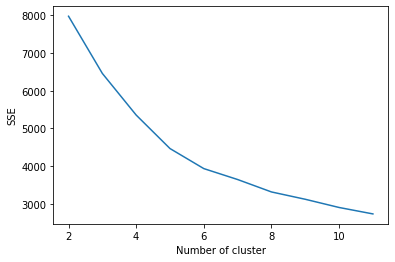

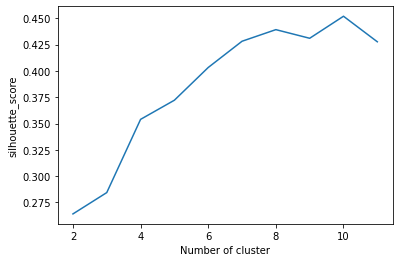

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

data = df_norm_covariates.sample(10000)
silhouette_array = []
sse = {}
for n_clusters in np.arange(2, 12):

    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data)
    sse[n_clusters] = clusterer.inertia_
    
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_array.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.figure()
plt.plot(np.arange(2,12),silhouette_array)
plt.xlabel("Number of cluster")
plt.ylabel("silhouette_score")

In [17]:
df_norm_covariates.describe()

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,GENERO_MASCULINO
count,141314.000000,141314.000000,141314.000000,141314.000000,141314.000000,141314.000000
mean,0.634225,2.183311,0.604208,0.545261,0.665398,0.919385
std,0.352312,0.392992,0.489022,0.497949,0.471853,0.272244
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,2.089342,0.000000,0.000000,0.000000,1.000000
50%,0.500000,2.316607,1.000000,1.000000,1.000000,1.000000
75%,0.900000,2.500000,1.000000,1.000000,1.000000,1.000000
max,1.800000,2.500000,1.000000,1.000000,1.000000,1.000000


In [174]:
df_norm_covariates_sample = df_norm_covariates.sample(10000)

A k-means model with 8 clusters is proposed.

In [18]:
k=8
clusterer = KMeans(n_clusters=k)
cluster_labels = clusterer.fit_predict(df_norm_covariates)

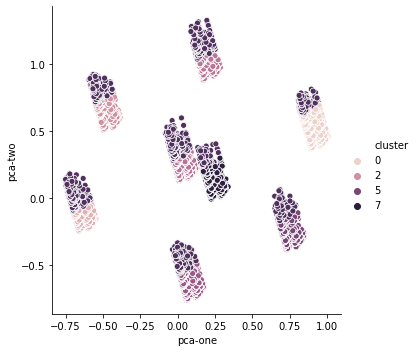

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit(df_norm_covariates).transform(df_norm_covariates)
datos_pca = df_norm_covariates.copy()
datos_pca['cluster'] = cluster_labels
datos_pca['pca-one'] = X[:,0]
datos_pca['pca-two'] = X[:,1]

sns.relplot(x="pca-one", y="pca-two", hue="cluster", data=datos_pca)

The descriptive analytics of the clusters is obtained in the next groupby:

In [36]:
pd.set_option('display.max_columns',500)
df_mj_cp_outcome = df_mj_cp[covariates].copy()
df_mj_cp_outcome.fillna(0,inplace=True)
df_mj_cp_outcome['cluster'] = cluster_labels
df_mj_cp_outcome.groupby(by='cluster').describe()

NIVEL_EDUCATIVO                                                \
                  count      mean       std  min  25%  50%  75%   max   
cluster                                                                 
0               15498.0  6.435024  3.590217  0.0  5.0  5.0  9.0  18.0   
1               25651.0  6.155627  3.467649  0.0  5.0  5.0  9.0  18.0   
2               20255.0  6.388003  3.436956  0.0  5.0  5.0  9.0  18.0   
3               24965.0  6.439055  3.419213  0.0  5.0  5.0  9.0  18.0   
4               29352.0  6.192185  3.475388  0.0  2.0  5.0  9.0  18.0   
5               12450.0  6.462490  3.527601  0.0  5.0  5.0  9.0  18.0   
6                7810.0  6.530474  4.159659  0.0  5.0  5.0  9.0  18.0   
7                5333.0  6.612976  3.554874  0.0  5.0  5.0  9.0  18.0   

        logDelito                                                       \
            count       mean       std       min        25%        50%   
cluster                                                                  
0         15498.0  10.413184  1.712009  4.871201  10.093469  10.730086   
1         25651.0  11.026081  0.997332  7.947937  10.730086  11.082596   
2         20255.0  10.359981  1.413297  6.568345  10.093469  10.730086   
3         24965.0  11.051444  1.028285  7.864848  10.730086  11.082596   
4         29352.0  10.640669  1.358276  6.568345  10.093469  11.082596   
5         12450.0  11.054041  1.251851  6.472271  10.730086  11.880779   
6          7810.0   6.048341  1.389235  1.000000   5.276666   6.220356   
7          5333.0  10.688866  1.520745  5.700480  10.093469  11.082596   

                              EN_CARCEL                                     \
               75%        max     count      mean       std  min  25%  50%   
cluster                                                                      
0        11.880779  11.880779   15498.0  0.000000  0.000000  0.0  0.0  0.0   
1        11.880779  11.880779   25651.0  1.000000  0.000000  1.0  1.0  1.0   
2        11.880779  11.880779   20255.0  1.000000  0.000000  1.0  1.0  1.0   
3        11.880779  11.880779   24965.0  0.000000  0.000000  0.0  0.0  0.0   
4        11.880779  11.880779   29352.0  1.000000  0.000000  1.0  1.0  1.0   
5        11.880779  11.880779   12450.0  0.000000  0.000000  0.0  0.0  0.0   
6         7.224558   7.947937    7810.0  0.613572  0.486962  0.0  0.0  1.0   
7        11.880779  11.880779    5333.0  1.000000  0.000000  1.0  1.0  1.0   

                  ACTIVIDADES_TRABAJO_SI                                     \
         75%  max                  count      mean       std  min  25%  50%   
cluster                                                                       
0        0.0  0.0                15498.0  0.000000  0.000000  0.0  0.0  0.0   
1        1.0  1.0                25651.0  1.000000  0.000000  1.0  1.0  1.0   
2        1.0  1.0                20255.0  1.000000  0.000000  1.0  1.0  1.0   
3        0.0  0.0                24965.0  1.000000  0.000000  1.0  1.0  1.0   
4        1.0  1.0                29352.0  0.000000  0.000000  0.0  0.0  0.0   
5        0.0  0.0                12450.0  0.000000  0.000000  0.0  0.0  0.0   
6        1.0  1.0                 7810.0  0.791549  0.406227  0.0  1.0  1.0   
7        1.0  1.0                 5333.0  0.000000  0.000000  0.0  0.0  0.0   

                  ACTIVIDADES_ESTUDIO_SI                                     \
         75%  max                  count      mean       std  min  25%  50%   
cluster                                                                       
0        0.0  0.0                15498.0  0.000000  0.000000  0.0  0.0  0.0   
1        1.0  1.0                25651.0  1.000000  0.000000  1.0  1.0  1.0   
2        1.0  1.0                20255.0  0.000000  0.000000  0.0  0.0  0.0   
3        1.0  1.0                24965.0  0.832926  0.373049  0.0  1.0  1.0   
4        0.0  0.0                29352.0  1.000000  0.000000  1.0  1.0  1.0   
5        0.0  0.0           

the model is saved as a Naive Bayes model and as a pure k-means model.

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, cohen_kappa_score


nb1 = GaussianNB()
y_pred = nb1.fit(df_mj_cp_outcome[covariates], df_mj_cp_outcome['cluster'])


In [31]:
import pickle
filename_nb1 = 'nb_model_no_education.sav'
pickle.dump(nb1, open(filename_nb1, 'wb'))

An analysis of the impact factor of the weights is checked with a random forest strategy

In [21]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 42)
randomForest.fit(df_mj_cp_outcome[covariates], df_mj_cp_outcome['cluster'])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

This model have a significat impact from the conviction place, working and study activities during conviction, and type of crime.

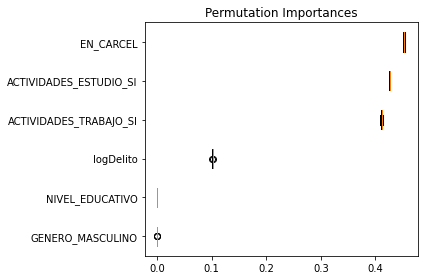

In [22]:
from sklearn.inspection import permutation_importance

result = permutation_importance(randomForest, df_mj_cp_outcome[covariates], df_mj_cp_outcome['cluster'], n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df_mj_cp_outcome[covariates].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [20]:
## Save K-Means 1 (No Education)
import pickle
filename_m1 = 'kmeans_model_no_education.sav'
pickle.dump(clusterer, open(filename_m1, 'wb'))

In [ ]:
## load model (if needed)
clusterer = pickle.load(open(filename_m1, 'rb'))

### Model 2 (high impact of the education level)

A second model is proposed with different weights to provide more weight to the education level and achieve different clusters description.

In [21]:
df_norm_covariates2 = normalize(df_mj_cp[covariates])
df_norm_covariates2.fillna(0,inplace=True)
df_norm_covariates2['logDelito'] = df_norm_covariates2['logDelito']*2
df_norm_covariates2['NIVEL_EDUCATIVO'] = df_norm_covariates2['NIVEL_EDUCATIVO']*3.5
df_norm_covariates2['GENERO_MASCULINO'] = df_norm_covariates2['GENERO_MASCULINO']*2
df_norm_covariates2

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,GENERO_MASCULINO
0,2.138889,1.788491,1.0,1.0,0.0,2.0
1,2.138889,1.671474,1.0,1.0,0.0,2.0
2,2.138889,1.671474,1.0,1.0,0.0,2.0
3,0.972222,1.788491,1.0,1.0,0.0,2.0
4,0.388889,1.788491,0.0,1.0,1.0,2.0
...,...,...,...,...,...,...
141309,0.388889,0.127408,0.0,1.0,0.0,2.0
141310,2.138889,0.127408,1.0,1.0,0.0,2.0
141311,0.972222,0.127408,1.0,0.0,0.0,2.0
141312,0.388889,0.127408,1.0,0.0,0.0,2.0


In [181]:
import matplotlib.pyplot as plt

The silhoutte score analysis is carried out.

For n_clusters = 2 The average silhouette_score is : 0.2526512815296398
For n_clusters = 3 The average silhouette_score is : 0.2378996742830697
For n_clusters = 4 The average silhouette_score is : 0.27648891159777994
For n_clusters = 5 The average silhouette_score is : 0.2886728747022327
For n_clusters = 6 The average silhouette_score is : 0.29786217511796004
For n_clusters = 7 The average silhouette_score is : 0.3343642874573801
For n_clusters = 8 The average silhouette_score is : 0.35737577175918195
For n_clusters = 9 The average silhouette_score is : 0.37216352904940014
For n_clusters = 10 The average silhouette_score is : 0.4150809595943338
For n_clusters = 11 The average silhouette_score is : 0.40853319736092036


Text(0, 0.5, 'silhouette_score')

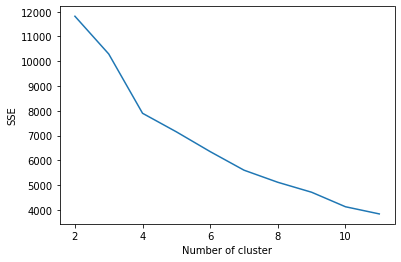

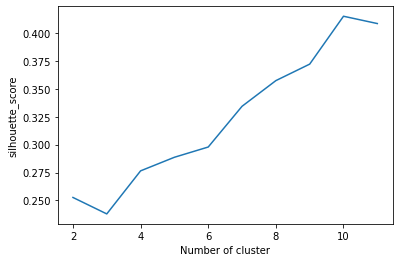

In [182]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


data = df_norm_covariates2.sample(10000)
silhouette_array = []
sse = {}
for n_clusters in np.arange(2, 12):

    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data)
    sse[n_clusters] = clusterer.inertia_
    
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_array.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.figure()
plt.plot(np.arange(2,12),silhouette_array)
plt.xlabel("Number of cluster")
plt.ylabel("silhouette_score")

A k-means model with 10 clusters is proposed for this second approach.

In [22]:
k=10
clusterer2 = KMeans(n_clusters=k)
cluster_labels2 = clusterer2.fit_predict(df_norm_covariates2)

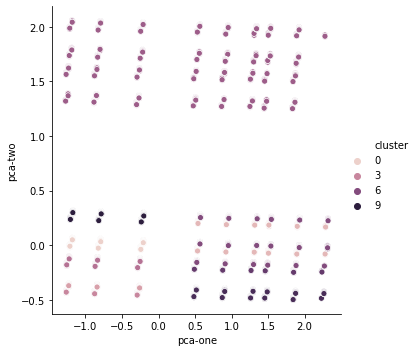

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit(df_norm_covariates2).transform(df_norm_covariates2)
datos_pca = df_norm_covariates2.copy()
datos_pca['cluster'] = cluster_labels2
datos_pca['pca-one'] = X[:,0]
datos_pca['pca-two'] = X[:,1]

sns.relplot(x="pca-one", y="pca-two", hue="cluster", data=datos_pca)

The descriptive analytics of the clusters is obtained in the next groupby:

In [37]:
df_mj_cp_outcome2 = df_mj_cp[covariates].copy()
df_mj_cp_outcome2.fillna(0,inplace=True)
df_mj_cp_outcome2['cluster'] = cluster_labels2
df_mj_cp_outcome2.groupby(by='cluster').describe()

NIVEL_EDUCATIVO                                                   \
                  count       mean       std  min  25%   50%   75%   max   
cluster                                                                    
0               14544.0   3.942863  1.549378  0.0  2.0   5.0   5.0   5.0   
1               12941.0  10.214126  1.471514  9.0  9.0  11.0  11.0  18.0   
2               12121.0   3.884993  1.560012  0.0  2.0   5.0   5.0   5.0   
3               16745.0   3.717647  1.655556  0.0  2.0   5.0   5.0   5.0   
4               19962.0   3.684851  1.659515  0.0  2.0   5.0   5.0   5.0   
5               11392.0   6.272735  3.713580  0.0  5.0   5.0   9.0  18.0   
6                9210.0  10.468295  1.788139  9.0  9.0  11.0  11.0  18.0   
7               11370.0  10.040018  1.238148  9.0  9.0   9.0  11.0  18.0   
8               18159.0  10.178424  1.447200  9.0  9.0   9.0  11.0  18.0   
9               14870.0   3.831002  1.602387  0.0  2.0   5.0   5.0   5.0   

        logDelito                                                             \
            count       mean       std  min        25%        50%        75%   
cluster                                                                        
0         14544.0  10.608849  1.712552  1.0  10.196647  11.082596  11.880779   
1         12941.0  10.833766  1.602697  1.0  10.730086  11.880779  11.880779   
2         12121.0  10.093162  1.743313  1.0   8.948738  10.730086  11.082596   
3         16745.0  10.511022  1.697563  1.0  10.093469  11.082596  11.880779   
4         19962.0  10.421994  1.674012  1.0  10.093469  11.082596  11.880779   
5         11392.0  10.526103  1.720323  1.0  10.196647  11.082596  11.880779   
6          9210.0  10.459623  1.881628  1.0  10.093469  11.082596  11.880779   
7         11370.0  10.580782  1.553321  1.0  10.093469  11.082596  11.880779   
8         18159.0  10.499684  1.645874  1.0  10.093469  11.082596  11.880779   
9         14870.0  10.493917  1.828770  1.0  10.093469  11.082596  11.880779   

                   EN_CARCEL                                               \
               max     count      mean       std  min  25%  50%  75%  max   
cluster                                                                     
0        11.880779   14544.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
1        11.880779   12941.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
2        11.880779   12121.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
3        11.880779   16745.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
4        11.880779   19962.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
5        11.880779   11392.0  0.430741  0.495202  0.0  0.0  0.0  1.0  1.0   
6        11.880779    9210.0  0.230076  0.420904  0.0  0.0  0.0  0.0  1.0   
7        11.880779   11370.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
8        11.880779   18159.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
9        11.880779   14870.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

        ACTIVIDADES_TRABAJO_SI                                               \
                         count      mean       std  min  25%  50%  75%  max   
cluster                                                                       
0                      14544.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
1                      12941.0  0.630709  0.482632  0.0  0.0  1.0  1.0  1.0   
2                      12121.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
3                      16745.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
4                      19962.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
5                      11392.0  0.496840  0.500012  0.0  0.0  0.0  1.0  1.0   
6                       9210.0  0.180456  0.384588  0.0  0.0  0.0  0.0  1.0   
7                      11370.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
8                      18159.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
9                      14870

The model is saved as a Naive Bayes model and as a k-means model.

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, cohen_kappa_score


nb2 = GaussianNB()
y_pred2 = nb2.fit(df_mj_cp_outcome2[covariates], df_mj_cp_outcome2['cluster'])

In [34]:
import pickle
filename_nb2 = 'nb_model_education.sav'
pickle.dump(nb2, open(filename_nb2, 'wb'))

The same strategy to analyze the weights of the covariates with the random forest approach is applied again in this model.

In [36]:
randomForest2 = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 42)
randomForest2.fit(df_mj_cp_outcome2[covariates], df_mj_cp_outcome2['cluster'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

This second approach has more impact from education level and gender, different from the first approach which was not very influenced by these variables.

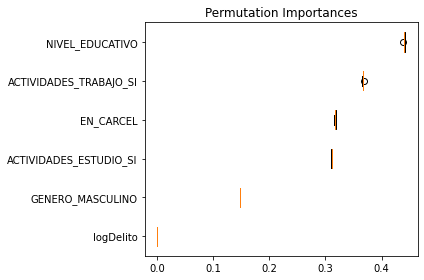

In [37]:
result = permutation_importance(randomForest2, df_mj_cp_outcome2[covariates], df_mj_cp_outcome2['cluster'], n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df_mj_cp_outcome2[covariates].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [25]:
## Save K-Means 2 (Education)
import pickle
filename_m2 = 'kmeans_model_education.sav'
pickle.dump(clusterer2, open(filename_m2, 'wb'))

In [ ]:
## load model (if needed)
clusterer2 = pickle.load(open(filename_m2, 'rb'))

In [191]:
print(len(cluster_labels))
df_norm_covariates

141314


,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,GENERO_MASCULINO
0,1.1,2.235613,1.0,1.0,0.0,1.0
1,1.1,2.089342,1.0,1.0,0.0,1.0
2,1.1,2.089342,1.0,1.0,0.0,1.0
3,0.5,2.235613,1.0,1.0,0.0,1.0
4,0.2,2.235613,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
141309,0.2,0.159260,0.0,1.0,0.0,1.0
141310,1.1,0.159260,1.0,1.0,0.0,1.0
141311,0.5,0.159260,1.0,0.0,0.0,1.0
141312,0.2,0.159260,1.0,0.0,0.0,1.0


In [38]:
df_mj_cp_clsts = df_mj_cp.copy()
df_mj_cp_clsts['cluster_1'] = cluster_labels
df_mj_cp_clsts['cluster_2'] = cluster_labels2
df_mj_cp_clsts = df_mj_cp_clsts[['INTERNOEN','cluster_1','cluster_2']]
df_mj_cp_clsts.to_csv('INTERNO_clusters.csv',index=False)
df_mj_cp_clsts

,INTERNOEN,cluster_1,cluster_2
0,FFFFB0916FD16C7AF652FF211662005C40F70E33,2,8
1,FFFFB0916FD16C7AF652FF211662005C40F70E33,2,8
2,FFFFB0916FD16C7AF652FF211662005C40F70E33,2,8
3,FFFE667F85CF452DB70B955609103CB72ECA3EEB,2,2
4,FFFADAD55F03CF9CCDFBC89749D5C1F96C1CBDCF,3,0
...,...,...,...
141309,56D98505E3C50A60B417E06A243EB2A3F54398B8,6,0
141310,40CB95694C223EC5F2F7C62092C4B36F875A4229,6,8
141311,620F88A3A6547F011C1F987C6E0E1B4688F3452C,6,4
141312,256DF79E4660D5212118EC685E40EF115A1BFC2B,6,4


## Classification

An additional approach to address supervised classification was proposed but was not successful.

The labels and inputs are defined. The output is based on recidivism level for each recidivist or offender.

In [10]:
labels_cf = ['REINCIDENCIA_LEVE','REINCIDENCIA_MODERADA','REINCIDENCIA_ALTA','REINCIDENCIA_POTENCIAL']
labels_grp_cf = ['LABEL']
inputs_cf = ['NIVEL_EDUCATIVO','logDelito','EN_CARCEL','EDAD']

In [11]:
df_clasf = df_mj_cp.copy()
df_clasf = df_clasf[inputs_cf + ['CANTIDAD_DELITOS']]
df_clasf.fillna(0,inplace=True)

The recidivism levels are allocated based on crime repetition for each entry in the dataset.

In [12]:
#df_labels = df_clasf['CANTIDAD_DELITOS']
#df_clasf['REINCIDENCIA_LEVE'] = np.where(df_clasf[df_clasf['CANTIDAD_DELITOS']]<=1,1,0)
#df_clasf
df_clasf['REINCIDENCIA_LEVE'] = df_clasf['CANTIDAD_DELITOS'].apply(lambda x: np.where(x<=1,1,0))
df_clasf['REINCIDENCIA_MODERADA'] = df_clasf['CANTIDAD_DELITOS'].apply(lambda x: np.where((x>1) & (x<=4),1,0))
df_clasf['REINCIDENCIA_ALTA'] = df_clasf['CANTIDAD_DELITOS'].apply(lambda x: np.where((x>4) & (x<=8),1,0))
df_clasf['REINCIDENCIA_POTENCIAL'] = df_clasf['CANTIDAD_DELITOS'].apply(lambda x: np.where(x>8,1,0))
df_clasf

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,EDAD,CANTIDAD_DELITOS,REINCIDENCIA_LEVE,REINCIDENCIA_MODERADA,REINCIDENCIA_ALTA,REINCIDENCIA_POTENCIAL
0,11.0,10.730086,1,29,3,0,1,0,0
1,11.0,10.093469,1,29,3,0,1,0,0
2,11.0,10.093469,1,29,3,0,1,0,0
3,5.0,10.730086,1,36,1,1,0,0,0
4,2.0,10.730086,0,46,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...
141309,2.0,1.693147,0,37,2,0,1,0,0
141310,11.0,1.693147,1,61,1,1,0,0,0
141311,5.0,1.693147,1,42,2,0,1,0,0
141312,2.0,1.693147,1,53,2,0,1,0,0


#### Bayes

A first approach and best result of the model was done implementing a Naive Bayes model.

In [13]:
map_reincidencia = {'REINCIDENCIA_LEVE' : 1, 'REINCIDENCIA_MODERADA':2,
                    'REINCIDENCIA_ALTA':3,'REINCIDENCIA_POTENCIAL':4}
df_labels = df_clasf[labels_cf][df_clasf[labels_cf]==1].stack().reset_index().drop(0,1).drop('level_0',axis=1)
df_clasf['LABEL'] = df_labels['level_1'].map(map_reincidencia)
df_clasf

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,EDAD,CANTIDAD_DELITOS,REINCIDENCIA_LEVE,REINCIDENCIA_MODERADA,REINCIDENCIA_ALTA,REINCIDENCIA_POTENCIAL,LABEL
0,11.0,10.730086,1,29,3,0,1,0,0,2
1,11.0,10.093469,1,29,3,0,1,0,0,2
2,11.0,10.093469,1,29,3,0,1,0,0,2
3,5.0,10.730086,1,36,1,1,0,0,0,1
4,2.0,10.730086,0,46,3,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...
141309,2.0,1.693147,0,37,2,0,1,0,0,2
141310,11.0,1.693147,1,61,1,1,0,0,0,1
141311,5.0,1.693147,1,42,2,0,1,0,0,2
141312,2.0,1.693147,1,53,2,0,1,0,0,2


In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_clasf[inputs_cf], df_clasf[labels_grp_cf],
                                                    test_size=0.2,random_state=42)


In [130]:
X_train

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,EDAD
21004,5.0,10.093469,1,34
19624,9.0,10.730086,0,32
77138,9.0,11.880779,1,37
47446,2.0,11.880779,1,34
55040,11.0,11.880779,0,31
...,...,...,...,...
110268,5.0,11.082596,0,40
119879,5.0,7.907755,0,32
103694,11.0,11.082596,0,24
131932,11.0,8.494430,1,28


In [156]:
y_train

,LABEL
21004,2
19624,2
77138,2
47446,2
55040,1
...,...
110268,1
119879,1
103694,1
131932,1


In [127]:
X_train[y_train == 4].sample(28260, replace = True)

X_train[y_train == 3].sample(28260, replace = True)


X_train[y_train == 1].sample(28260, replace = True)


X_train[y_train == 2].sample(28260, replace = False)

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,EDAD
34580,NaN,NaN,NaN,NaN
51701,NaN,NaN,NaN,NaN
106588,NaN,NaN,NaN,NaN
100580,NaN,NaN,NaN,NaN
25550,NaN,NaN,NaN,NaN
...,...,...,...,...
22382,NaN,NaN,NaN,NaN
124336,NaN,NaN,NaN,NaN
26162,NaN,NaN,NaN,NaN
126937,NaN,NaN,NaN,NaN


In [162]:
train_4 = X_train[y_train.isin([4]).values].sample(28260,replace=True)
train_4['y'] = 4


train_3 = X_train[y_train.isin([3]).values].sample(28260,replace=True)
train_3['y'] = 3

train_1 = X_train[y_train.isin([1]).values].sample(28260,replace=True)
train_1['y'] = 1

train_2 = X_train[y_train.isin([2]).values].sample(28260,replace=True)
train_2['y'] = 2

train = pd.concat([train_1, train_2, train_3, train_4], axis = 0)
train

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,EDAD,y
116935,9.0,11.082596,1,36,1
42389,5.0,11.880779,0,35,1
35607,5.0,10.093469,0,36,1
40591,16.0,11.880779,0,35,1
113126,11.0,11.082596,0,25,1
...,...,...,...,...,...
12992,2.0,10.730086,1,43,4
29548,2.0,8.948738,1,32,4
73787,5.0,5.553877,1,44,4
63630,5.0,11.880779,0,47,4


In [164]:
train['y'].value_counts()

4    28260
3    28260
2    28260
1    28260
Name: y, dtype: int64

In [159]:
X_train[y_train.isin([2]).values].dropna()
#y_train.isin([2]).values

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,EDAD
21004,5.0,10.093469,1,34
19624,9.0,10.730086,0,32
77138,9.0,11.880779,1,37
47446,2.0,11.880779,1,34
133225,2.0,5.276666,1,70
...,...,...,...,...
126324,11.0,10.196647,1,28
112727,2.0,11.082596,0,49
87498,2.0,11.880779,0,28
137337,5.0,7.274762,1,45


The model is implemented with an accuracy of 0.62 (moderate result) but a poor cohen kappa score, which means a poor correlation or effect between the inputs to predict the labels.

In [119]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, cohen_kappa_score


nb = GaussianNB()
y_pred = nb.fit(X_train, y_train).predict(X_test)

acc = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f'''
Accuracy: {acc}
Kappa: {kappa}
''')


Accuracy: 0.6289848919081484
Kappa: 0.013383629761744564



/home/santiago/.local/lib/python3.6/site-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [163]:
nb = GaussianNB()
y_pred = nb.fit(train[inputs_cf], train['y']).predict(X_test)

acc = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f'''
Accuracy: {acc}
Kappa: {kappa}
''')


Accuracy: 0.44181438630010966
Kappa: 0.0328812774259839



The model is able of predict some of the redicivism levels per offender, but it tends to associate all the entries with recidivism level 2.

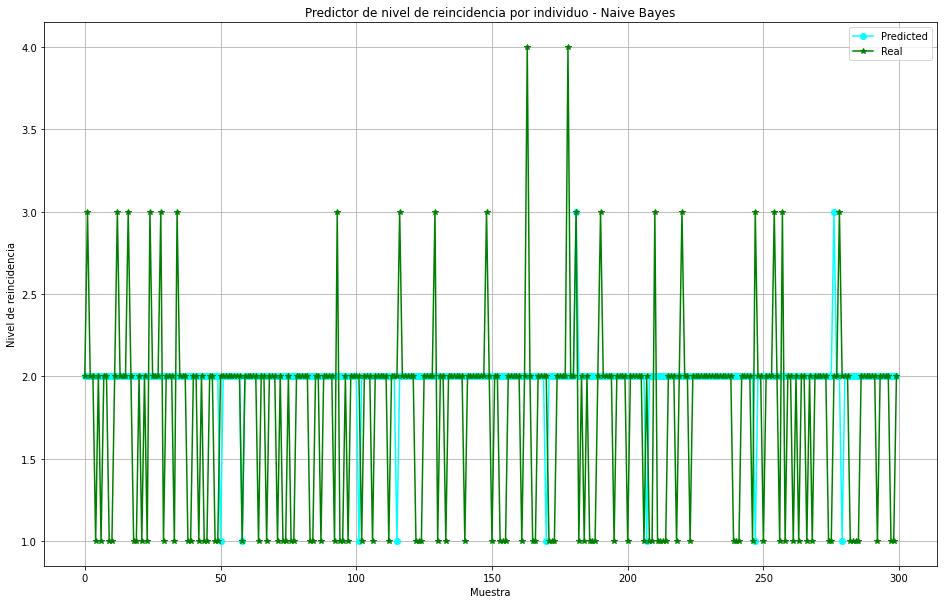

In [121]:
plt.figure(figsize=(16,10))
plt.plot(y_pred[0:300],marker='o',color='cyan')
plt.plot(y_test.values[0:300],color='green',marker='*')
plt.legend(['Predicted','Real'])
plt.title('Predictor de nivel de reincidencia por individuo - Naive Bayes')
plt.ylabel('Nivel de reincidencia')
plt.xlabel('Muestra')
plt.grid()
plt.show()

In [122]:
df_clasf['LABEL'].value_counts()

2    90118
1    39082
3    11617
4      497
Name: LABEL, dtype: int64

In [123]:
unique, counts = np.unique(y_pred,return_counts=True)
np.asarray((unique, counts)).T

array([[    1,   476],
       [    2, 27526],
       [    3,   210],
       [    4,    51]])

In [124]:
y_test['LABEL'].value_counts()

2    17953
1     7844
3     2373
4       93
Name: LABEL, dtype: int64

### Neural Networks

A second approach was proposed implementing neural networks but poor results were obtained.

In [17]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [47]:
y_train_cat = y_train.astype("category")
y_train_cat = pd.get_dummies(y_train_cat)
y_test_cat = y_test.astype("category")
y_test_cat = pd.get_dummies(y_test_cat)
y_train_cat

,LABEL_1,LABEL_2,LABEL_3,LABEL_4
21004,0,1,0,0
19624,0,1,0,0
77138,0,1,0,0
47446,0,1,0,0
55040,1,0,0,0
...,...,...,...,...
110268,1,0,0,0
119879,1,0,0,0
103694,1,0,0,0
131932,1,0,0,0


In [165]:
model_cf = Sequential()
model_cf.add(Dense(128, input_dim=4))
#model_cf.add(Dense(24, activation='relu'))
model_cf.add(Dense(128, activation='relu'))
model_cf.add(Dense(4, activation='sigmoid'))
model_cf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
history = model_cf.fit(X_train.values, y_train_cat.values, validation_split=0.2, epochs=10, steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 2s 22ms/step - loss: 0.9616 - accuracy: 0.6199 - val_loss: 0.9382 - val_accuracy: 0.6356
Epoch 2/10
100/100 [==============================] - 2s 20ms/step - loss: 0.9414 - accuracy: 0.6309 - val_loss: 0.9362 - val_accuracy: 0.6409
Epoch 3/10
100/100 [==============================] - 2s 20ms/step - loss: 0.9354 - accuracy: 0.6357 - val_loss: 0.8634 - val_accuracy: 0.6444
Epoch 4/10
100/100 [==============================] - 2s 19ms/step - loss: 0.8772 - accuracy: 0.6368 - val_loss: 0.8643 - val_accuracy: 0.6444
Epoch 5/10
100/100 [==============================] - 2s 21ms/step - loss: 0.8705 - accuracy: 0.6368 - val_loss: 0.8560 - val_accuracy: 0.6444
Epoch 6/10
100/100 [==============================] - 2s 20ms/step - loss: 0.8735 - accuracy: 0.6368 - val_loss: 0.8578 - val_accuracy: 0.6444
Epoch 7/10
100/100 [==============================] - 2s 19ms/step - loss: 0.8673 - accuracy: 0.6368 - val_loss: 0.8582 - val_accuracy: 0.6444

In [79]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.873459,0.636831,0.857827,0.644377,5
6,0.867286,0.636831,0.858173,0.644377,6
7,0.870100,0.636831,0.859377,0.644377,7
8,0.867866,0.636831,0.868537,0.644377,8
9,0.870022,0.636831,0.861254,0.644377,9


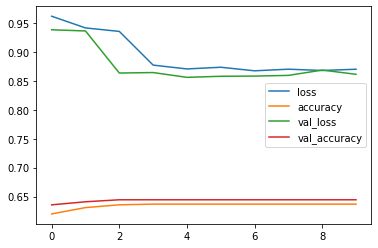

In [80]:
hist.drop(columns=["epoch"]).plot()

In [81]:
predicted_targets = model_cf.predict(X_test.values)
predicted_targets

array([[0.5005365 , 0.9989656 , 0.07814851, 0.00143626],
       [0.55981094, 0.999995  , 0.14004502, 0.00364387],
       [0.47672677, 0.99988455, 0.11620092, 0.00257948],
       ...,
       [0.45085728, 0.999709  , 0.10778692, 0.00407025],
       [0.5371458 , 0.99997234, 0.12220067, 0.00649071],
       [0.6030611 , 0.9999218 , 0.16908492, 0.02067276]], dtype=float32)

The model tends to associate all the entries with the recidivism level 2.

In [106]:
predicted_targets_df = pd.DataFrame(predicted_targets)
predicted_targets_df = predicted_targets_df.apply(lambda x: np.where(x>0.8,1,0))
predicted_targets_df.columns = ["LABEL_1","LABEL_2","LABEL_3","LABEL_4"]
predicted_targets_df

,LABEL_1,LABEL_2,LABEL_3,LABEL_4
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
28258,0,1,0,0
28259,0,1,0,0
28260,0,1,0,0
28261,0,1,0,0


In [101]:
for col in predicted_targets_df.columns.values:
    print("Value counts for column " + col +  ": ")
    print(predicted_targets_df[col].value_counts())

Value counts for column LABEL_1: 
0    28082
1      181
Name: LABEL_1, dtype: int64
Value counts for column LABEL_2: 
1    28263
Name: LABEL_2, dtype: int64
Value counts for column LABEL_3: 
0    28263
Name: LABEL_3, dtype: int64
Value counts for column LABEL_4: 
0    28263
Name: LABEL_4, dtype: int64


In [102]:
y_test_cat.values

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=uint8)

In [112]:
#predicted_targets_df.set_index('ID',inplace=True)
predicted_targets_df_final=predicted_targets_df[predicted_targets_df==1].stack().reset_index().drop(0,1).drop('level_0',axis=1)
predicted_targets_df_final

,level_1
0,LABEL_2
1,LABEL_2
2,LABEL_2
3,LABEL_2
4,LABEL_2
...,...
28439,LABEL_2
28440,LABEL_2
28441,LABEL_2
28442,LABEL_2


In [113]:
map_labels = {
    'LABEL_1':1,
    'LABEL_2':2,
    'LABEL_3':3,
    'LABEL_4':4
}
predicted_targets_df_final['LABEL']=predicted_targets_df_final['level_1'].map(map_labels)
predicted_targets_df_final

,level_1,LABEL
0,LABEL_2,2
1,LABEL_2,2
2,LABEL_2,2
3,LABEL_2,2
4,LABEL_2,2
...,...,...
28439,LABEL_2,2
28440,LABEL_2,2
28441,LABEL_2,2
28442,LABEL_2,2


In [116]:
unique_elements, counts_elements = np.unique(predicted_targets_df_final['LABEL'].round(), return_counts=True)
print("Value counts:")
print(np.asarray((unique_elements, counts_elements)).T)

Value counts:
[[    1   181]
 [    2 28263]]


The model predicts almost every entry to label 2 (recidivism level 2), perhaps it is due to an imbalanced dataset.

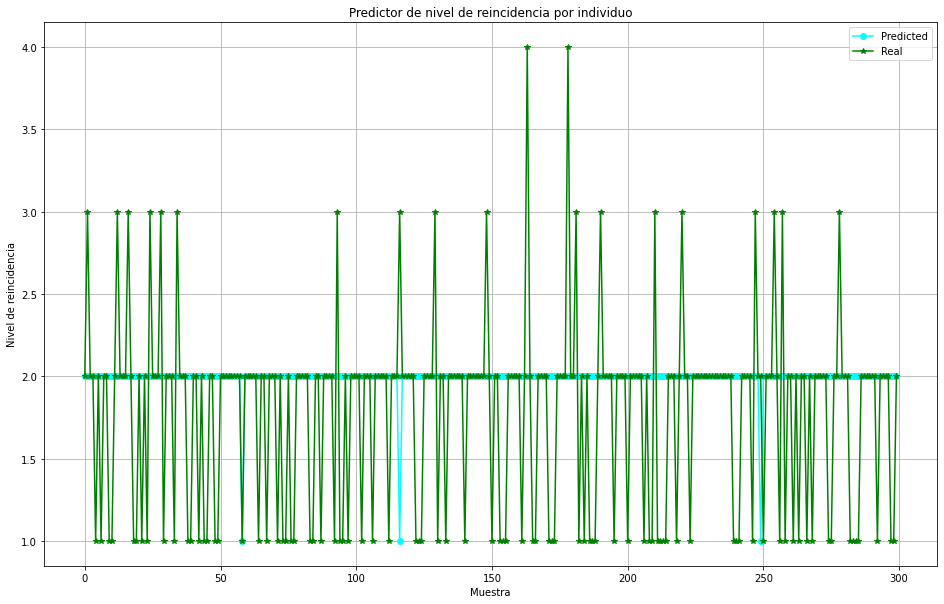

In [118]:
plt.figure(figsize=(16,10))
plt.plot(predicted_targets_df_final['LABEL'][0:300],marker='o',color='cyan')
plt.plot(y_test.values[0:300],color='green',marker='*')
plt.legend(['Predicted','Real'])
plt.title('Predictor de nivel de reincidencia por individuo')
plt.ylabel('Nivel de reincidencia')
plt.xlabel('Muestra')
plt.grid()
plt.show()

### Random Forest

A final approach was proposed using random forest for the same purpose but again, it gave poor results

In [89]:
from sklearn import ensemble
randomForest_clf = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 4)
randomForest_clf.fit(X_train, y_train)

/home/santiago/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [90]:
rdm_predict = randomForest_clf.predict(X_train)
rdm_predict

array([2, 2, 2, ..., 2, 2, 2])

In [93]:
unique_elements, counts_elements = np.unique(rdm_predict, return_counts=True)
print("Value counts:")
print(np.asarray((unique_elements, counts_elements)).T)

Value counts:
[[     1      3]
 [     2 113048]]


Again, the model associates almost every entry in the dataset to label 2 (recidivism level 2), which corroborates an imbalanced dataset for this supervised classification method.

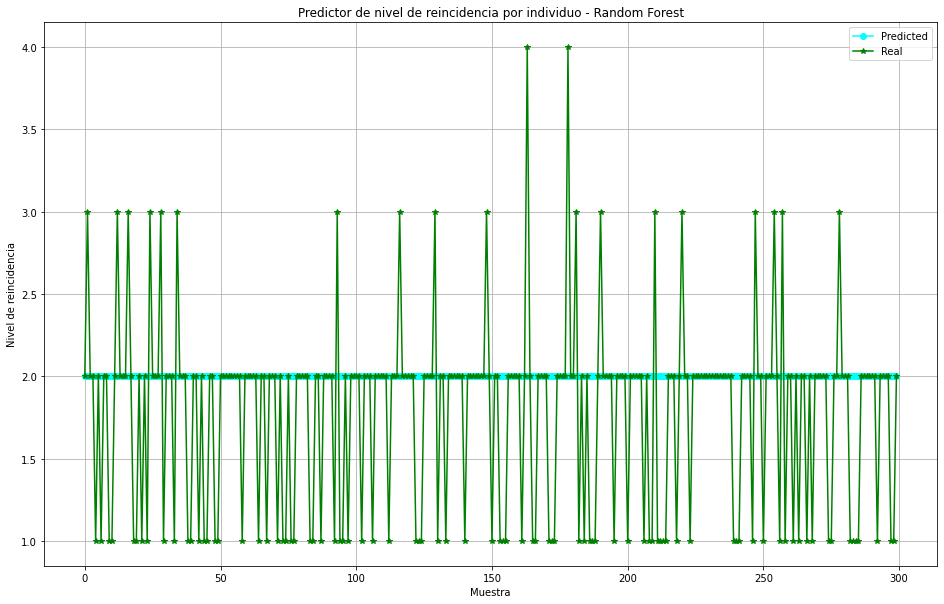

In [92]:
plt.figure(figsize=(16,10))
plt.plot(rdm_predict[0:300],marker='o',color='cyan')
plt.plot(y_test.values[0:300],color='green',marker='*')
plt.legend(['Predicted','Real'])
plt.title('Predictor de nivel de reincidencia por individuo - Random Forest')
plt.ylabel('Nivel de reincidencia')
plt.xlabel('Muestra')
plt.grid()
plt.show()